In [1]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from enum import Enum
import mediapipe as mp
import yaml

from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [2]:
DATA_ROOT = Path("../../data/")
# VIDEO_NAME = Path("VID_20230814_102451798.mp4")
# VIDEO_NAME = Path("private/VID_20230815_160238697.mp4")
VIDEO_NAME = Path("yt/01.mp4")

# check if the video exists
if not (DATA_ROOT / VIDEO_NAME).exists():
    raise FileNotFoundError(f"Video not found: {DATA_ROOT / VIDEO_NAME}")

# open video file with opencv
video_reader = cv2.VideoCapture(str(DATA_ROOT/VIDEO_NAME))

# check if video opened successfully
if (video_reader.isOpened() == False):
    raise Exception(f"Error opening video stream or file: {DATA_ROOT/VIDEO_NAME}")
    
width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
# print video properties
print("Video properties:")
print("  - frame width:  ", width)
print("  - frame height: ", height)
print("  - frame count:  ", frames_count)
print("  - frame rate:   ", video_reader.get(cv2.CAP_PROP_FPS))

Video properties:
  - frame width:   1920
  - frame height:  1080
  - frame count:   91
  - frame rate:    29.95


In [3]:
MODEL_INPUT_HEIGHT = 257
MODEL_INPUT_WIDTH = 257
CONFIDENCE_THRESHOLD = 0.5
MODEL_PATH = Path("models/deeplabv3.tflite")
LABELS_PATH = Path("models/deeplabv3_labels.yaml")

base_options = python.BaseOptions(model_asset_path=str(DATA_ROOT / MODEL_PATH))
options = vision.ImageSegmenterOptions(base_options=base_options,
                                       output_category_mask=True)

labels = yaml.safe_load((DATA_ROOT / LABELS_PATH).read_text())
person_label = int(labels.get("labels").get("person"))

In [4]:
MASK_COLOR = (0, 0, 0)
video_reader.set(cv2.CAP_PROP_POS_FRAMES, 0)
backgrounds = []
with python.vision.ImageSegmenter.create_from_options(options) as segmenter:
    for frame_index in tqdm(range(frames_count-1)):
        _, frame = video_reader.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)

        # Retrieve the masks for the segmented image
        segmentation_result = segmenter.segment(image)
        confidence_mask = segmentation_result.confidence_masks[person_label]

        # Generate solid color images for showing the output segmentation mask.
        image_data = image.numpy_view()
        fg_image = np.zeros(image_data.shape, dtype=np.uint8)
        fg_image[:] = MASK_COLOR

        condition = np.stack((confidence_mask.numpy_view(),) * 3, axis=-1) > CONFIDENCE_THRESHOLD
        output_image = np.where(condition, fg_image, image_data)

        backgrounds.append(output_image)

100%|██████████| 90/90 [00:26<00:00,  3.38it/s]


In [5]:
current_frame = None
op_flow = []
accumulated_op_flow = []
video_reader.set(cv2.CAP_PROP_POS_FRAMES, 0)
for frame_index in tqdm(range(frames_count-1)):
    if current_frame is None:
        _, current_frame = video_reader.read()
    _, next_frame = video_reader.read()

    gray1 = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 5, 21, 5, 5, 1.2, 0)

    op_flow.append(flow)
    if frame_index == 0:
        accumulated_op_flow.append(flow)
    else:
        accumulated_op_flow.append(accumulated_op_flow[-1] + flow)
    current_frame = next_frame

100%|██████████| 90/90 [01:12<00:00,  1.24it/s]


In [6]:
projected_images = []
for frame_index in tqdm(range(30)): # tqdm(range(len(accumulated_op_flow))):
    background_image = backgrounds[frame_index]
    optical_flow = accumulated_op_flow[frame_index]

    optical_flow = cv2.GaussianBlur(optical_flow, (51, 51), 0)

    # # Create zero padding for the optical flow
    
    # padded_flow = np.pad(optical_flow, ((padding_height, padding_height), (padding_width, padding_width), (0, 0)), mode='constant')
    # padded_background = np.pad(background_image, ((padding_height, padding_height), (padding_width, padding_width), (0, 0)), mode='constant')
    
    # # Generate grid for remapping on the larger canvas
    # x_new, y_new = np.meshgrid(np.linspace(0, new_width - 1, new_width),
    #                         np.linspace(0, new_height - 1, new_height))

    # # Apply reverse optical flow to compute source coordinates on the original image
    # x_source = x_new - padded_flow[:,:,0]
    # y_source = y_new - padded_flow[:,:,1]

    # # Remap the original image onto the larger canvas
    # extended_background = cv2.remap(padded_background, x_source.astype(np.float32), y_source.astype(np.float32), interpolation=cv2.INTER_LINEAR)


    x_new, y_new = np.meshgrid(np.linspace(0, backgrounds[0].shape[1] - 1, backgrounds[0].shape[1]),
                             np.linspace(0, backgrounds[0].shape[0] - 1, backgrounds[0].shape[0]))
    x_source = x_new + 2*optical_flow[:,:,0]
    y_source = y_new + 2*optical_flow[:,:,1]

    extended_background = cv2.remap(background_image, x_source.astype(np.float32), y_source.astype(np.float32), interpolation=cv2.INTER_LINEAR)
    projected_images.append(extended_background)
    cv2.imwrite(f'./output/extended_background_minus_{frame_index:02}.png', extended_background)
    

100%|██████████| 30/30 [00:04<00:00,  6.46it/s]


In [16]:
projected_images = []
for frame_index in tqdm(range(len(accumulated_op_flow))):
    background_image = backgrounds[frame_index]
    optical_flow = accumulated_op_flow[frame_index]

    u_mean = np.mean(optical_flow[:,:,0])
    v_mean = np.mean(optical_flow[:,:,1])

    mask = background_image[:,:,0] > 0
    masked_flow = optical_flow[:,:,0][mask]
    u_mean = np.mean(masked_flow)
    masked_flow = optical_flow[:,:,1][mask]
    v_mean = np.mean(masked_flow)

    transform_matrix = np.float32([[1, 0, 0], [0, 1, 0]])
    transform_matrix[0,2] = -u_mean*1
    transform_matrix[1,2] = -v_mean*1
    
    extended_background = cv2.warpAffine(background_image, transform_matrix, (background_image.shape[1], background_image.shape[0]))

    projected_images.append(extended_background)
    cv2.imwrite(f'./output/affine_minus_{frame_index:02}.png', extended_background)
    

100%|██████████| 90/90 [00:08<00:00, 10.85it/s]


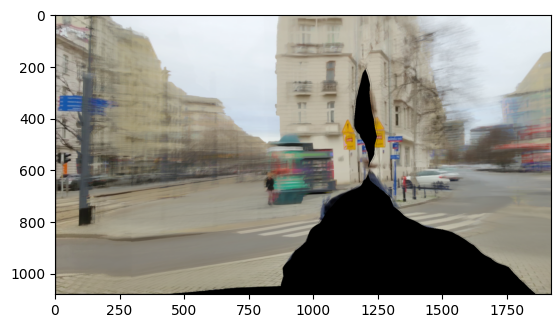

In [17]:
median_image = np.ma.median(np.ma.masked_less(projected_images, 5.0), axis=0)
plt.imshow(median_image.astype(np.uint8))

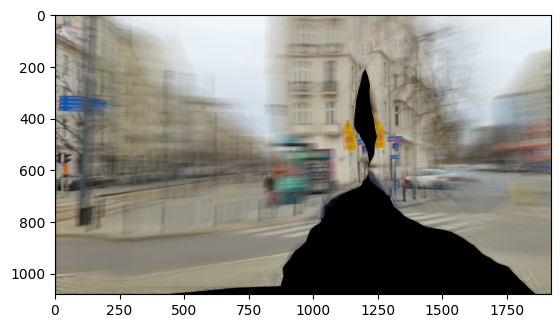

In [18]:
mean_image = np.mean(np.ma.masked_less(projected_images, 5.0), axis=0)
plt.imshow(mean_image.astype(np.uint8))

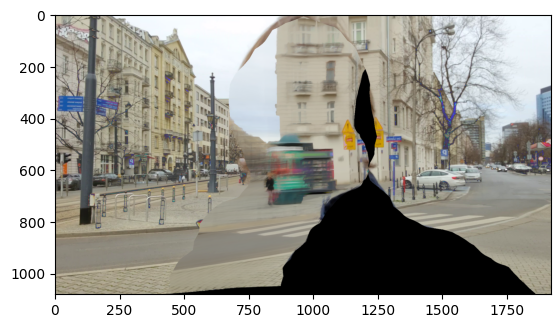

In [19]:
inpaint_image = median_image.copy()
background_image = backgrounds[0].copy()

composite = np.where(background_image < 50.0, inpaint_image, background_image)

plt.imshow(composite.astype(np.uint8))


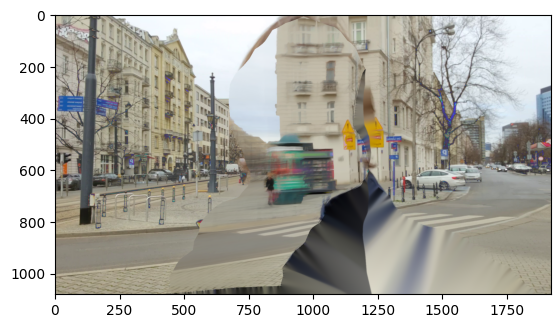

In [20]:
inpaint_mask = composite[:,:,0] == 0
inpaint_mask = inpaint_mask.astype(np.uint8)
inpaint = cv2.inpaint(composite.astype(np.uint8), inpaint_mask, 3, cv2.INPAINT_TELEA)
plt.imshow(inpaint)

In [21]:
from PIL import Image

def blending_with_mask(background, foreground, mask, foreground_weight) -> np.ndarray:
    """Blends the foreground and background images using the mask.
    Args:
        background: The background image.
        foreground: The foreground image.
        mask: The mask of the foreground image.
        foreground_weight: The weight of the foreground image.
    Returns:
        The blended image.
    """
    background = background.astype(np.float32)
    foreground = foreground.astype(np.float32)
    mask = mask.astype(np.float32)
    blended = (1.0 - mask) * background + mask * foreground_weight * foreground + mask * (1.0 - foreground_weight) * background

    return blended.astype(np.uint8)

frames = []
background_image = inpaint.copy()
foreground_mask = (backgrounds[0] == 0).astype(np.uint8)
video_reader.set(cv2.CAP_PROP_POS_FRAMES, 0)
_, foreground_image = video_reader.read()
foreground_image = cv2.cvtColor(foreground_image, cv2.COLOR_BGR2RGB)
for i in tqdm(range(0, 100)):
    blended = blending_with_mask(background_image, foreground_image, foreground_mask, 1.0 - (i / 100.0))
    frames.append(blended)
gif_frames = [Image.fromarray(img) for img in frames]
gif_frames[0].save("bg_01.gif", save_all=True, append_images=gif_frames[1:], duration=50, loop=0)

100%|██████████| 100/100 [00:10<00:00,  9.37it/s]


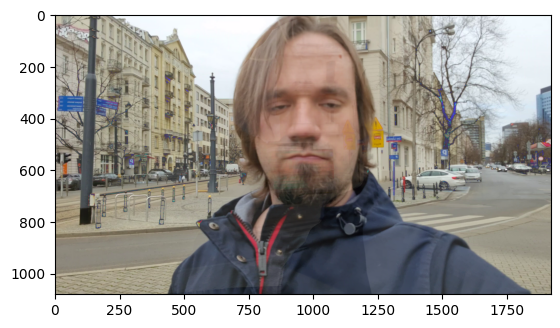

In [23]:
blended = blending_with_mask(background_image, foreground_image, foreground_mask, 0.8)
plt.imshow(blended)

In [26]:
for bg_index in tqdm(range(len(backgrounds))):
    bg = backgrounds[bg_index]
    output_path = f'./output/{bg_index:02d}.png'
    cv2.imwrite(output_path, bg)

  0%|          | 0/90 [00:00<?, ?it/s]

100%|██████████| 90/90 [00:07<00:00, 12.83it/s]
